In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

warnings.filterwarnings(action='ignore')

### 앙상블 학습 (211p)
- **배깅** : 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅을 수행하는 것
    - 부트스트래핑 분할 방식 : 개별 분류기에게 데이터를 샘플링해서 추출하는 방식
- **보팅** : 일반적으로 서로 다른 알고리즘을 가진 분류기를 결합하는 것
    - 하드 보팅 : 다수결(다수의 선택) voting
    - 소프트 보팅 : 확률의 평균을 이용한 voting
- **부스팅** : 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에 가중치를 부여하면서 학습과 예측을 진행하는 것

- 배깅 앙상블 : 부트스트래핑 방식으로 샘플링 된 데이터 세트에 대해서 학습을 통해 개별적인 예측을 수행한 결과를 보팅을 통해 최종 결과를 예측하는 방식

### 보팅 분류기(Voting Classifier) (214p)

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# 개별 모델 : 로지스틱 회귀 모델, KNN
model1 = LogisticRegression()
model2 = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
voting = VotingClassifier(estimators=[('Logistic', model1), ('KNN', model2)], voting='soft')

X_train, X_valid, y_train, y_valid = train_test_split(cancer.data, cancer.target, 
                                                     test_size=0.2, random_state=156)

# Voting 학습 / 예측 / 평가
voting.fit(X_train, y_train)
pred = voting.predict(X_valid)
print(f'Voting 분류기 정확도 : {accuracy_score(y_valid, pred):.4f}')

# 개별 모델의 학습 / 예측 / 평가
classifiers = [model1, model2]

for model in classifiers:
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    model_name = model.__class__.__name__
    print(f'{model_name}의 정확도 : {accuracy_score(y_valid, pred):.4f}')

Voting 분류기 정확도 : 0.9474
LogisticRegression의 정확도 : 0.9386
KNeighborsClassifier의 정확도 : 0.9386


보팅으로 여러 개 분류기를 결합한다고 해서 무조건 성능이 개선되는 것은 아니지만, 전반적으로 다른 단일 ML 알고리즘보다 뛰어난 예측 성능을 가지는 경우가 많다.

### Random Forest (217p)
-> 배깅의 대표적인 알고리즘

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## features.txt에는 피처이름 index와 피처명이 공백으로 분리되어 있음.
feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+', 
                             header=None, names=['column_index', 'column_name'])

## 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()

feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

dup_list = feature_dup_df[feature_dup_df['column_index']>1].index

for dup in dup_list:
    temp_list = feature_name_df.loc[feature_name_df['column_name']==dup, 'column_name']
    for num, idx, val in list(zip([1, 2, 3], temp_list.index, temp_list.values)):
        feature_name_df.loc[idx, 'column_name'] = val + f'_{num}'
        
feature_name = feature_name_df['column_name'].values

# 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
X_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)

# 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
y_train = pd.read_csv('./data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
y_test = pd.read_csv('./data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

column_index    42
dtype: int64


In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [8]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)

score = accuracy_score(y_test, pred)
print(f'랜덤 포레스트 정확도 : {score:.4f}')

랜덤 포레스트 정확도 : 0.9253


#### GridSearchCV를 이용한 하이퍼 파라미터 튜닝

In [10]:
%%time
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

# RandomForest 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=3)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=3)
grid_cv.fit(X_train, y_train)

print(f'최적 하이퍼 파라미터 : {grid_cv.best_params_}')
print(f'최고 예측 정확도 : {grid_cv.best_score_:.4f}')

최적 하이퍼 파라미터 : {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180
Wall time: 32.5 s


-> n_estimators = 300

In [18]:
rf_clf_1 = RandomForestClassifier(
                                    max_depth=10, 
                                    min_samples_leaf=8, 
                                    min_samples_split=8, 
                                    n_estimators=300,
                                    random_state=0, 
                                    n_jobs=-1
                                 )

rf_clf_1.fit(X_train, y_train)
pred = rf_clf_1.predict(X_test)
print(f'예측 정확도 : {accuracy_score(y_test, pred):.4f}')

예측 정확도 : 0.9165


#### 피쳐 중요도 출력

<AxesSubplot:>

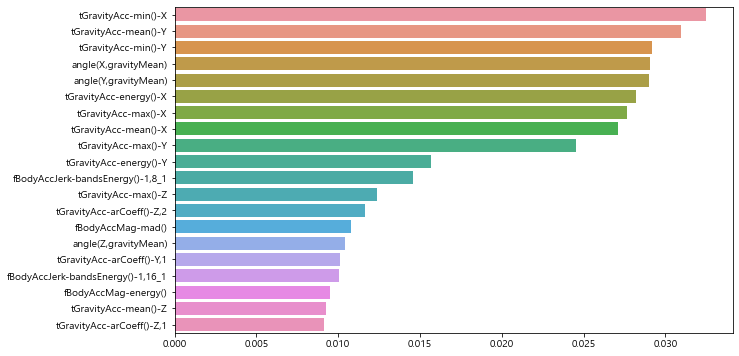

In [23]:
import seaborn as sns

feat_imp = pd.Series(rf_clf_1.feature_importances_, index=X_train.columns)
top20 = feat_imp.sort_values(ascending=False)[0:20]

plt.figure(figsize=(10,6), facecolor='white')
sns.barplot(y=top20.index, x=top20)

### GBM(Gradient Boosting Machine) (222p)

에이다 부스트(AdaBoost) - 약한 학습기가 순차적으로 오류 값에 대해 가중치를 부여한 예측 결정 기준을 모두 결합해 예측을 수행함

GBM(Gradient Boosting Machine)과 차이점 - 가중치 업데이트를 경사 하강법을 이용하냐의 차이

경사 하강법(Gradient Descent) - $h(x) = y - F(x)$ 의 값을 최소화하는 방향성을 가지고 반복적으로 가중치의 값을 업데이트 하는 것

$h(x)$ : 오류식, $y$ : 실제값, $F(x)$ : 피처에 기반한 예측 함수

In [100]:
from sklearn.ensemble import GradientBoostingClassifier
import time

## 시작 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
pred = gb_clf.predict(X_test)
score = accuracy_score(y_test, pred)

print(f'GBM 정확도 : {score*100:.4f}')
print(f'GBM 수행 시간 : {time.time()-start_time}')

GBM 정확도 : 93.8921
GBM 수행 시간 : 548.3644046783447


#### GridSearchCV를 이용한 하이퍼 파라미터 최적화

In [101]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 500], 
    'learning_rate': [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'최적의 하이퍼 파라미터 : {grid_cv.best_params_}')
print(f'최고 예측 정확도 : {grid_cv.best_score_:.4f}')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 102.8min finished


최적의 하이퍼 파라미터 : {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도 : 0.9011
